In [1]:
import numpy as np
np.random.seed(1)
import networks as nt
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42})
plt.rcParams.update({'font.size': 10, 'font.family': 'Helvetica'})
from matplotlib import patches

In [2]:
parameters = 'Biological'
cycles = ['exci-one', 'inhi-many', 'inhi-targ']
times_P = [0.25, 0.35, 0.6, 0.7]
times_P = [0.25, 0.35, 0.55, 0.65]
N = 100
neurons_P = [[37], np.random.choice(N, int(0.4*N)), np.arange(int(0.30*N), int(0.46*N))]
mag_P = [0, np.inf, np.inf]

N = 35
neurons_P = [[11], np.random.choice(N, int(0.4*N)), np.arange(6, 16)]
mag_P = [-1, np.inf, np.inf]

threshold = 0.5 # 1.5  1. 0.7 0.55 0.5
D_length = 0.5

seed_network = 1
s_mag = 3
time_c_each = 1

no_rows = 2
height_ratios = [3, 2]
alpha_rect = 0.3
color_i = '#6281c1'
color_r = '#676766'
color_between_error = '#6281c1'
marker_size = 2
marker_alpha = 1
scale = 0.302769505
figsize = (scale * 6 * (len(cycles) + 1), scale * 10)
lw_signal = 0.5
lw_readout = 0.25

In [3]:
def signal(T_r, T_c, no_turns, dt):
    Xr = np.zeros((T_r + 1, 2))
    Xr[:, 0] = s_mag * np.linspace(0, 1, T_r + 1)
    Xc = np.zeros((no_turns * T_c + 1, 2))
    time = np.linspace(0, no_turns * 2 * np.pi, no_turns * T_c + 1)
    Xc[:, 0] = s_mag * np.cos(time)
    Xc[:, 1] = s_mag * np.sin(time)
    X = np.vstack((Xr[:-1, :], Xc))
    Xdot = np.diff(X.T).T / dt
    return X[:-1, :], Xdot

In [4]:
def readout_correction(R, D, threshold, D_length):
    Xh_c = np.zeros((R.shape[0], D.shape[0]))
    for i in range(R.shape[0]):
        xh = np.dot(D, R[i, :])
        if np.linalg.norm(xh) > 0:
            Xh_c[i, :] = xh * (1 + ((threshold / D_length) - (D_length / 2)) / np.linalg.norm(xh))
    return Xh_c

In [5]:
def plot_result(Xh, X, Spikes, order_neurons, color_p=color_i, save=True):
    fig, (ax_s, ax_r) = plt.subplots(no_rows, 1, figsize=figsize, gridspec_kw={'height_ratios': height_ratios})
    ax_s.plot(Xh, color=color_r, lw=lw_readout)
    ax_s.plot(X, color='black', lw=lw_signal)
    for i, cycle in enumerate(cycles):
        st = T_r + (i + 1) * T_c
        ax_s.axvspan(st + T1, st + T2, color=color_p, alpha=alpha_rect, ec=None)
        ax_s.axvspan(st + T3, st + T4, color=color_p, alpha=alpha_rect, ec=None)

        for height in range(N):
            neuron = order_neurons[height]
            neuron = height
            if neuron in neurons_P[i]:
                rect = patches.Rectangle((st + T1, height - 0.5), T2 - T1, 1, facecolor=color_p, alpha=alpha_rect)
                ax_r.add_patch(rect)
                rect = patches.Rectangle((st + T3, height - 0.5), T4 - T3, 1, facecolor=color_p, alpha=alpha_rect)
                ax_r.add_patch(rect)

    verts = list(zip([-0.2,-0.2,0.2,0.2,-0.2,-0.2],[-0.8,0.8,0.8,-0.8,-0.8,0]))
    for height in range(N):
        neuron = order_neurons[height]
        ax_r.scatter(Spikes[neuron], height * np.ones(len(Spikes[neuron])), marker='|', linewidths=0.5, color='gray', s=marker_size, alpha=marker_alpha)     
    
    ax_s.set_xlim([T_r, T])
    ax_s.set_xticks(np.linspace(T_r, T, 5))
    ax_s.set_xticklabels([])
    ax_s.spines['right'].set_visible(False)
    ax_s.spines['top'].set_visible(False)
    
    ax_r.set_xticks(np.linspace(T_r, T, 5))
    ax_r.set_xticks(np.linspace(T_r, T, 5))
    ax_r.set_xticklabels([0, 1, 2, 3, 4])
    ax_r.set_xlim([T_r, T])
    ax_r.set_ylim([-1, N])
    ax_r.set_yticks([])
    ax_r.spines['left'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['top'].set_visible(False)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(hspace=0.1)
    if save:
        fig.savefig('FIG4A.pdf', transparent=True)

In [6]:
d_sim, d_pert, d_seed = nt.create_parameters(parameters, time_c=time_c_each, error_points_t = 30)
lambd, ref_t, delay, noise = d_sim['lambd'], d_sim['ref_t'], d_sim['delay'], d_sim['noise']
dt, time_r, T_r, time_c, T_c = d_sim['dt'], d_sim['time_r'], d_sim['T_r'], d_sim['time_c'], d_sim['T_c']
step_t, signal_noise, reset = d_sim['step_t'], d_sim['signal_noise'], d_sim['reset']

ref_t = 0.001
reset = 0.4
noise = 0.2

no_turns = len(cycles) + 1
Lambd = lambd * np.ones(N)
T = T_r + no_turns * T_c

T1, T2, T3, T4 = [int(t * time_c_each / dt) for t in times_P]

In [7]:
D = np.zeros((2, N))
angles = np.linspace(0, 2 * np.pi, N + 1)[:-1]
D[0, :] = np.cos(angles)
D[1, :] = np.sin(angles)
D *= D_length
F = D.copy().T
Omega = np.dot(D.T, D)
for i in range(N):
    Omega[i, i] *= 2 ** reset
Th = threshold * np.ones(N)

R0, V0 = np.zeros(N), np.zeros(N)

X, Xdot = signal(T_r, T_c, no_turns, dt)

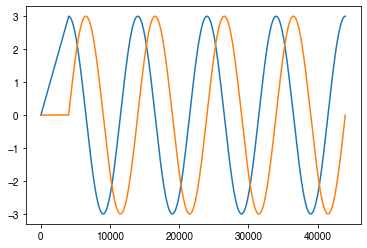

In [8]:
plt.plot(X);

dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.044044044044044044 average saturated neuron: 0.0012584012584012584
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.048 average saturated neuron: 0.0013714285714285714
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 0.0001 ref 10 delay 0 N 35 most saturated neuron:  0.0 average

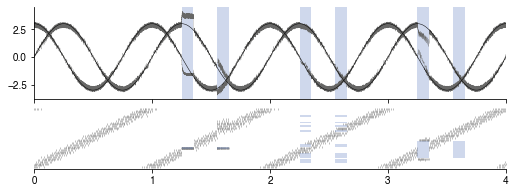

In [9]:
dV = np.sqrt(dt) * noise * np.random.randn(T, N)

R_r, Spikes_r, Rc, Vc = nt.simnumba(F, Omega, Th, lambd * X[:T_r, :] + Xdot[:T_r, :], dt, dV[:T_r, :], Lambd, lambd, delay, R0, V0, ref_t=ref_t)
time_sim = np.arange(T_r, T_r + T_c)
R, Spikes, Rc, Vc = nt.simnumba(F, Omega, Th, lambd * X[time_sim, :] + Xdot[time_sim, :], dt, dV[time_sim, :], Lambd, lambd, delay, Rc, Vc, ref_t=ref_t)
order_neurons = np.arange(N)
R = np.vstack((R_r, R))
Spikes = [Spikes_r[i] + [spike + T_r for spike in Spikes[i]] for i in range(N)]
    

for i, cycle in enumerate(cycles):
    st = T_r + (i + 1) * T_c
    
    Th_p = Th.copy()
    Th_p[order_neurons[neurons_P[i]]] *= mag_P[i]  
    
    time_sim = np.arange(st, st + T1)
    R_bf, Spikes_bf, Rc, Vc = nt.simnumba(F, Omega, Th, lambd * X[time_sim, :] + Xdot[time_sim, :], dt, dV[time_sim, :], Lambd, lambd, delay, Rc, Vc, ref_t=ref_t)
    R = np.vstack((R, R_bf))
    Spikes = [Spikes[i] + [spike + time_sim[0] for spike in Spikes_bf[i]] for i in range(N)]
    
    time_sim = np.arange(st + T1, st + T2)
    R_d1, Spikes_d1, Rc, Vc = nt.simnumba(F, Omega, Th_p, lambd * X[time_sim, :] + Xdot[time_sim, :], dt, dV[time_sim, :], Lambd, lambd, delay, Rc, Vc, ref_t=ref_t)
    R = np.vstack((R, R_d1))
    Spikes = [Spikes[i] + [spike + time_sim[0] for spike in Spikes_d1[i]] for i in range(N)]
    
    time_sim = np.arange(st + T2, st + T3)
    R_bt, Spikes_bt, Rc, Vc = nt.simnumba(F, Omega, Th, lambd * X[time_sim, :] + Xdot[time_sim, :], dt, dV[time_sim, :], Lambd, lambd, delay, Rc, Vc, ref_t=ref_t)
    R = np.vstack((R, R_bt))
    Spikes = [Spikes[i] + [spike + time_sim[0] for spike in Spikes_bt[i]] for i in range(N)]
    
    time_sim = np.arange(st + T3, st + T4)
    R_d2, Spikes_d2, Rc, Vc = nt.simnumba(F, Omega, Th_p, lambd * X[time_sim, :] + Xdot[time_sim, :], dt, dV[time_sim, :], Lambd, lambd, delay, Rc, Vc, ref_t=ref_t)
    R = np.vstack((R, R_d2))
    Spikes = [Spikes[i] + [spike + time_sim[0] for spike in Spikes_d2[i]] for i in range(N)]
    
    time_sim = np.arange(st + T4, st + T_c)
    R_af, Spikes_af, Rc, Vc = nt.simnumba(F, Omega, Th, lambd * X[time_sim, :] + Xdot[time_sim, :], dt, dV[time_sim, :], Lambd, lambd, delay, Rc, Vc, ref_t=ref_t)
    R = np.vstack((R, R_af))
    Spikes = [Spikes[i] + [spike + time_sim[0] for spike in Spikes_af[i]] for i in range(N)]

Xh = readout_correction(R, D, threshold, D_length)    
plot_result(Xh, X, Spikes, order_neurons)